# 1) Imports

#### PyTorch

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, OneCycleLR

In [2]:
print('PyTorch version', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

PyTorch version 2.9.1+cu128
Device: cuda


#### General

In [3]:
import os
import json
import math
import time
import random
from pathlib import Path
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

from sklearn.metrics import roc_auc_score

#### Monai

In [4]:
import monai
print("MONAI version:", monai.__version__)

MONAI version: 1.5.1


In [5]:
from monai.networks.nets import UNet as MonaiUNet
from monai.losses import DiceCELoss
from monai.utils import set_determinism
from monai.transforms import (
    Compose,
    RandFlipd,
    RandRotate90d,
    RandZoomd,
    RandAffined,
    RandGaussianNoised,
    RandShiftIntensityd,
    RandScaleIntensityd,
    EnsureTyped,
)

# 2) Parameters

#### 2.1) Directories

In [6]:
drive_root = Path("/home/usrs/hnoel/DRIVE_608")

# TRAIN = 20 images (21–40)
train_images_dir = drive_root / "training" / "images"
train_manual_dir = drive_root / "training" / "1st_manual"   # 21_manual1.gif, ...
train_fov_dir    = drive_root / "training" / "mask"        # 21_training_mask.tif, ...

# TEST = 20 images (01–20)
test_images_dir  = drive_root / "test" / "images"
test_manual_dir  = drive_root / "test" / "1st_manual"       # 01_manual1.gif, ...
test_fov_dir     = drive_root / "test" / "mask" 

#### 2.2) Hyperparameters

In [7]:
# Image sizes
IMG_HEIGHT = 608
IMG_WIDTH  = 608

# Batch size
BATCH_SIZE = 6

# Number of epochs
EPOCHS = 200

# Learning rate
LR = 1e-3

# Classes
NUM_CLASSES = 2
BACKGROUND_IDX = 0
VESSEL_CLASS = 1

#### 2.3) Seed

In [8]:
SEED = 42

# Python
random.seed(SEED)

# NumPy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Monai
set_determinism(seed=SEED)

print(f"Seed fixed to {SEED}")

Seed fixed to 42


#### 2.4) Save directories

In [9]:
model_name = "UNet_DRIVE_v1"

# Courbes, JSON, figures, etc.
data_dir = Path("/home/usrs/hnoel/Tohoku/Monai/UNet") / model_name
data_dir.mkdir(parents=True, exist_ok=True)

# Poids de modèles
models_dir = Path("/home/usrs/hnoel/MODELS/UNet") / model_name
models_dir.mkdir(parents=True, exist_ok=True)

# 3) DataLoaders

#### 3.1) Data augmentation

In [10]:
from monai.transforms import (
    Compose,
    ScaleIntensityd,
    RandFlipd,
    RandRotated,
    RandAffined,
    Resized,
    EnsureTyped,
)
import numpy as np

# ================
# TRANSFORMATIONS
# ================

# Toujours imposer (H,W) à la fin à cause des rotations sur images non carrées
final_size = (IMG_HEIGHT, IMG_WIDTH)   # (584, 565)

train_transforms = Compose([

    # Normalisation sur image uniquement
    ScaleIntensityd(keys=["image"]),

    # ---- AUGMENTATIONS ----
    RandFlipd(keys=["image", "label", "fov"], spatial_axis=0, prob=0.5),
    RandFlipd(keys=["image", "label", "fov"], spatial_axis=1, prob=0.5),

    RandRotated(
        keys=["image", "label", "fov"],
        range_x=np.pi/8,        # ±22.5°
        prob=0.3,
        mode=("bilinear", "nearest", "nearest"),
    ),

    RandAffined(
        keys=["image", "label", "fov"],
        prob=0.3,
        rotate_range=(-np.pi/12, np.pi/12),
        translate_range=(20, 20),
        scale_range=(0.05, 0.05),
        mode=("bilinear", "nearest", "nearest"),
    ),

    # ---- Fix dimension finale ----
    Resized(
        keys=["image", "label", "fov"],
        spatial_size=final_size,
        mode=("bilinear", "nearest", "nearest"),
    ),

    EnsureTyped(keys=["image", "label", "fov"]),
])

# -------------------
# Validation / Test
# -------------------

val_transforms = Compose([
    ScaleIntensityd(keys=["image"]),
    Resized(
        keys=["image", "label", "fov"],
        spatial_size=final_size,
        mode=("bilinear", "nearest", "nearest"),
    ),
    EnsureTyped(keys=["image", "label", "fov"]),
])


#### 3.2) Create the class fot the DRIVE datset images

In [11]:
class DriveDataset(Dataset):
    def __init__(self, img_dir, manual_dir, fov_dir,
                 img_size=(IMG_HEIGHT, IMG_WIDTH),
                 transforms=None,
                 indices=None):
        self.img_paths = sorted(list(Path(img_dir).glob("*.tif")))
        self.manual_dir = Path(manual_dir)
        self.fov_dir    = Path(fov_dir)
        self.H, self.W  = img_size   # H=584, W=565
        self.transforms = transforms
        self.indices    = indices

    def __len__(self):
        if self.indices is None:
            return len(self.img_paths)
        return len(self.indices)

    def _get_paths(self, idx):
        if self.indices is not None:
            idx = self.indices[idx]

        img_path = self.img_paths[idx]
        base = img_path.stem              # ex: "21_training"
        num  = base.split("_")[0]

        manual_path = self.manual_dir / f"{num}_manual1.gif"

        candidates = list(self.fov_dir.glob(f"{base}_mask.*"))
        if len(candidates) == 0:
            raise FileNotFoundError(f"No FOV mask found for {base} in {self.fov_dir}")
        fov_path = candidates[0]

        return img_path, manual_path, fov_path

    def __getitem__(self, idx):
        img_path, manual_path, fov_path = self._get_paths(idx)

        H, W = self.H, self.W   # force : (584, 565)

        # === Image ===
        img = Image.open(img_path).convert("RGB")
        img = img.resize((W, H), Image.BILINEAR)   # FORCE SHAPE (W,H)
        img_np = np.array(img).astype(np.float32) / 255.0
        img_t  = torch.from_numpy(img_np).permute(2, 0, 1)  # (3,H,W)

        # === GT vessels ===
        gt = Image.open(manual_path).convert("L")
        gt = gt.resize((W, H), Image.NEAREST)
        gt_np = np.array(gt)
        label_np = np.zeros_like(gt_np, dtype=np.int64)
        label_np[gt_np > 0] = VESSEL_CLASS
        label_t = torch.from_numpy(label_np).long().unsqueeze(0)

        # === FOV ===
        fov = Image.open(fov_path).convert("L")
        fov = fov.resize((W, H), Image.NEAREST)
        fov_np = (np.array(fov) > 0).astype(np.uint8)
        fov_t = torch.from_numpy(fov_np).long().unsqueeze(0)

        sample = {"image": img_t, "label": label_t, "fov": fov_t}

        if self.transforms is not None:
            sample = self.transforms(sample)

        return sample

In [12]:
# ========= Préparation des indices train / val sur TRAINING (21–40) =========
train_img_paths_all = sorted(list(Path(train_images_dir).glob("*.tif")))
train_nums = [int(p.stem.split("_")[0]) for p in train_img_paths_all]

"""
Validation on 22, 29, 31, 35
22 = Côtes d'Armor 
29 = Finistère
31 = Haute-Garonne
35 = Ille-et-Vilaine
"""
val_nums = {22, 29, 31, 35}
val_indices = [i for i, n in enumerate(train_nums) if n in val_nums]
train_indices = [i for i, n in enumerate(train_nums) if n not in val_nums]

print("Train indices (image numbers):", [train_nums[i] for i in train_indices])
print("Val indices (image numbers):  ", [train_nums[i] for i in val_indices])

# ========= Datasets =========
train_ds = DriveDataset(
    train_images_dir,
    train_manual_dir,
    train_fov_dir,
    img_size=(IMG_HEIGHT, IMG_WIDTH),
    transforms=train_transforms,
    indices=train_indices,
)

val_ds = DriveDataset(
    train_images_dir,
    train_manual_dir,
    train_fov_dir,
    img_size=(IMG_HEIGHT, IMG_WIDTH),
    transforms=val_transforms,
    indices=val_indices,
)

test_ds = DriveDataset(
    test_images_dir,
    test_manual_dir,
    test_fov_dir,
    img_size=(IMG_HEIGHT, IMG_WIDTH),
    transforms=val_transforms,
    indices=None,
)

# ========= DataLoaders =========
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Train / Val / Test sizes:", len(train_ds), len(val_ds), len(test_ds))


Train indices (image numbers): [21, 23, 24, 25, 26, 27, 28, 30, 32, 33, 34, 36, 37, 38, 39, 40]
Val indices (image numbers):   [22, 29, 31, 35]
Train / Val / Test sizes: 16 4 20


# 4) UNet Model

In [13]:
model = MonaiUNet(
    spatial_dims=2,                             # UNet in 2D
    in_channels=3,                              # images RGB => 3 channels
    out_channels=NUM_CLASSES,                   # 2 classes : background + vessels
    channels=(64, 128, 256, 512, 1024),         # number of feature channels at each level
    strides=(2, 2, 2, 2),                       # 4 steps of downsampling (implicite max-pool 2x2)
    kernel_size=3,                              # conv 3x3
    up_kernel_size=3,                           # up-conv 3x3
    num_res_units=0,                            # no residual units -> simple blocs conv+ReLU
    act="RELU",                                 # Use ReLU, defaults is PReLU 
    norm="instance",                                  # no normalization in the 2015 article
    dropout=0.0,                                # No dropout here
).to(device)

In [14]:
print(model.__class__.__name__, "initialized on", device)

UNet initialized on cuda


# 5) Optimizer

In [15]:
optimizer = optim.AdamW(
    model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=1e-2
    )

# 6) Scheduler

In [16]:
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=50,   # tous les 50 epochs
    gamma=0.5       # LR = LR * 0.5
)

# 7) Loss function

In [17]:
# Pour DRIVE (binaire), on commence sans pondération explicite des classes.
# Si besoin, on pourra recalculer des poids plus tard à partir des fréquences de pixels.
weights = None

In [18]:
loss_function = DiceCELoss(
    include_background=False,   # on ne compte pas le background dans le Dice
    to_onehot_y=True,
    softmax=True,
    weight=weights,
    lambda_dice=1.0,
    lambda_ce=1.0,
)

# 8) History and metrics

In [27]:
best_val_loss = float("inf")
best_val_dice = -float("inf")

In [28]:
# ===========================================
#   DICTIONNAIRES STOCRAGE (MEAN ONLY)
# ===========================================

train_history = {
    "loss": [],
    "accuracy":   [],
    "dice":       [],
    "iou":        [],
    "precision":  [],
    "recall":     [],
    "sensitivity":[],
    "specificity":[],
    "auc":        [],
    "lr":         [],
    "alpha":      []
}

val_history = {
    "loss": [],
    "accuracy":   [],
    "dice":       [],
    "iou":        [],
    "precision":  [],
    "recall":     [],
    "sensitivity":[],
    "specificity":[],
    "auc":        []
}

In [29]:
def init_confmat_sums(num_classes=NUM_CLASSES):
    """
    Agrégats TP/FP/FN/TN sur l'ensemble du dataset.
    N = nombre de pixels pris en compte (dans le FOV).
    """
    sums = {
        "TP": np.zeros(num_classes, dtype=np.int64),
        "FP": np.zeros(num_classes, dtype=np.int64),
        "FN": np.zeros(num_classes, dtype=np.int64),
        "TN": np.zeros(num_classes, dtype=np.int64),
        "N":  0,
    }
    return sums

In [30]:
def init_auc_buffers(classes):
    """
    Buffers pour stocker y_true / y_score par classe (liste d'indices de classes).
    Exemple : classes = [VESSEL_CLASS].
    """
    buffers = {}
    for c in classes:
        buffers[c] = {"y_true": [], "y_score": []}
    return buffers

In [31]:
def update_confmat_sums(sums, preds, targets, num_classes=NUM_CLASSES, fov=None):
    """
    Met à jour les compteurs TP/FP/FN/TN pour chaque classe.
    preds, targets, fov : tensors (N,H,W)
    Seuls les pixels avec fov == 1 sont pris en compte (si fov n'est pas None).
    """
    with torch.no_grad():
        if fov is not None:
            f = fov.bool()
        else:
            f = None

        for c in range(num_classes):
            p = (preds == c)
            t = (targets == c)

            if f is not None:
                p = p & f
                t = t & f

            tp = (p & t).sum().item()
            fp = (p & ~t).sum().item()
            fn = (~p & t).sum().item()
            tn = (~p & ~t).sum().item()

            sums["TP"][c] += tp
            sums["FP"][c] += fp
            sums["FN"][c] += fn
            sums["TN"][c] += tn

        if f is not None:
            sums["N"] += f.sum().item()
        else:
            sums["N"] += targets.numel()


In [32]:
def update_auc_buffers(buffers, logits, targets, fov=None):
    """
    Stocke y_true / y_score pour calculer l'AUC par classe ensuite.
    - logits: (N,C,H,W)
    - targets: (N,H,W)
    - fov: (N,H,W) ou None
    Seuls les pixels avec fov == 1 sont pris en compte.
    """
    with torch.no_grad():
        probs = F.softmax(logits, dim=1)  # (N,C,H,W)

        flat_probs = probs.permute(0, 2, 3, 1).reshape(-1, probs.shape[1])
        flat_t     = targets.reshape(-1)

        if fov is not None:
            flat_f = fov.reshape(-1).bool()
            flat_probs = flat_probs[flat_f]
            flat_t     = flat_t[flat_f]

        for c in buffers.keys():
            y_true  = (flat_t == c).cpu().numpy().astype(np.uint8)
            y_score = flat_probs[:, c].cpu().numpy()
            buffers[c]["y_true"].append(y_true)
            buffers[c]["y_score"].append(y_score)

In [33]:
def compute_scalar_metrics_from_confmat(sums, include_classes):
    """
    Calcule accuracy / precision / recall / specificity / dice / IoU
    en moyenne sur les classes listées (ex: [VESSEL_CLASS]).
    """
    TP, FP, FN, TN = sums["TP"], sums["FP"], sums["FN"], sums["TN"]
    eps = 1e-7

    acc_c  = (TP + TN) / np.maximum(TP + TN + FP + FN, eps)
    prec_c = TP / np.maximum(TP + FP, eps)
    rec_c  = TP / np.maximum(TP + FN, eps)
    spec_c = TN / np.maximum(TN + FP, eps)
    dice_c = (2 * TP) / np.maximum(2 * TP + FP + FN, eps)
    iou_c  = TP / np.maximum(TP + FP + FN, eps)

    idx = np.array(include_classes, dtype=int)
    return {
        "accuracy":    float(np.mean(acc_c[idx])),
        "precision":   float(np.mean(prec_c[idx])),
        "recall":      float(np.mean(rec_c[idx])),
        "specificity": float(np.mean(spec_c[idx])),
        "dice":        float(np.mean(dice_c[idx])),
        "iou":         float(np.mean(iou_c[idx])),
    }

In [34]:
def compute_mean_auc(buffers):
    """
    Calcule l'AUC moyen en moyennant sur les classes présentes dans `buffers`.
    """
    aucs = []
    for c, pack in buffers.items():
        if len(pack["y_true"]) == 0:
            continue
        y_true  = np.concatenate(pack["y_true"])
        y_score = np.concatenate(pack["y_score"])

        pos = (y_true == 1).sum()
        neg = (y_true == 0).sum()
        if pos == 0 or neg == 0:
            continue

        try:
            aucs.append(roc_auc_score(y_true, y_score))
        except Exception:
            pass

    if len(aucs) == 0:
        return float("nan")
    return float(np.mean(aucs))

# 9) Training

In [35]:
for epoch in range(EPOCHS):

    # =========================
    #        TRAIN
    # =========================
    model.train()

    running_loss = 0.0
    conf_sums = init_confmat_sums()
    auc_buf   = init_auc_buffers([VESSEL_CLASS])

    for batch in train_loader :

        imgs   = batch["image"].to(device, non_blocking=True)
        masks = batch["label"].to(device, non_blocking=True)
        fov    = batch["fov"].to(device, non_blocking=True)

        optimizer.zero_grad()

        outputs = model(imgs)  # (N,C,H,W)
        loss    = loss_function(outputs, masks)  # Dice + CE (MONAI)

        loss.backward()
        optimizer.step()

        batch_size = imgs.size(0)
        running_loss += loss.item() * batch_size

        preds = outputs.argmax(dim=1)
        update_confmat_sums(conf_sums, preds, masks, NUM_CLASSES)
        update_auc_buffers(auc_buf, outputs, masks)

    train_loss   = running_loss / len(train_ds)
    train_metrics = compute_scalar_metrics_from_confmat(conf_sums, [VESSEL_CLASS])
    train_auc     = compute_mean_auc(auc_buf)

    current_lr = optimizer.param_groups[0]["lr"]

    train_history["loss"].append(train_loss)
    train_history["accuracy"].append(train_metrics["accuracy"])
    train_history["dice"].append(train_metrics["dice"])
    train_history["iou"].append(train_metrics["iou"])
    train_history["precision"].append(train_metrics["precision"])
    train_history["recall"].append(train_metrics["recall"])
    train_history["specificity"].append(train_metrics["specificity"])
    train_history["auc"].append(train_auc)
    train_history["lr"].append(current_lr)

    # =========================
    #       VALIDATION
    # =========================
    model.eval()

    val_running_loss = 0.0
    conf_sums_val = init_confmat_sums()
    auc_buf_val   = init_auc_buffers(classes=[VESSEL_CLASS])

    with torch.no_grad():
        for batch in val_loader :

            imgs   = batch["image"].to(device, non_blocking=True)
            masks = batch["label"].to(device, non_blocking=True)
            fov    = batch["fov"].to(device, non_blocking=True)

            outputs = model(imgs)
            loss    = loss_function(outputs, masks)

            batch_size = imgs.size(0)
            val_running_loss += loss.item() * batch_size

            preds = outputs.argmax(dim=1)
            update_confmat_sums(conf_sums_val, preds, masks, NUM_CLASSES)
            update_auc_buffers(auc_buf_val, outputs, masks)

    val_loss    = val_running_loss / len(val_ds)
    val_metrics = compute_scalar_metrics_from_confmat(conf_sums_val, [VESSEL_CLASS])
    val_auc     = compute_mean_auc(auc_buf_val)

    val_history["loss"].append(val_loss)
    val_history["accuracy"].append(val_metrics["accuracy"])
    val_history["dice"].append(val_metrics["dice"])
    val_history["iou"].append(val_metrics["iou"])
    val_history["precision"].append(val_metrics["precision"])
    val_history["recall"].append(val_metrics["recall"])
    val_history["specificity"].append(val_metrics["specificity"])
    val_history["auc"].append(val_auc)

    # =========================
    #        LOGS
    # =========================
    print("-" * 40)
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}")
    print(f"  Train Dice: {train_metrics['dice']:.4f} | Val Dice: {val_metrics['dice']:.4f}")
    print(f"  Current LR: {current_lr:.6f}")

    # =========================
    #   SAVE BEST MODELS
    # =========================
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), str(models_dir / "loss_best_model_state_dict.pth"))
        torch.save(model,              str(models_dir / "loss_best_model_full.pth"))
        print("✅ New best model (loss) saved")

    if val_metrics["dice"] > best_val_dice:
        best_val_dice = val_metrics["dice"]
        torch.save(model.state_dict(), str(models_dir / "dice_best_model_state_dict.pth"))
        torch.save(model,              str(models_dir / "dice_best_model_full.pth"))
        print("✅ New best model (dice) saved")

    # =========================
    #   SCHEDULER STEP
    # =========================
    scheduler.step()

# =========================
#     SAVE LAST MODEL
# =========================
torch.save(model.state_dict(), str(models_dir / f"epoch{EPOCHS}_model_state_dict.pth"))
torch.save(model,              str(models_dir / f"epoch{EPOCHS}_model_full.pth"))
print("✅ Last model saved")


----------------------------------------
Epoch 1/200
  Train Loss: 1.0909
  Val   Loss: 0.9867
  Train Dice: 0.1141 | Val Dice: 0.1577
  Current LR: 0.001000
✅ New best model (loss) saved
✅ New best model (dice) saved
----------------------------------------
Epoch 2/200
  Train Loss: 0.9548
  Val   Loss: 0.8746
  Train Dice: 0.1570 | Val Dice: 0.2033
  Current LR: 0.001000
✅ New best model (loss) saved
✅ New best model (dice) saved
----------------------------------------
Epoch 3/200
  Train Loss: 0.8397
  Val   Loss: 0.7665
  Train Dice: 0.1830 | Val Dice: 0.2241
  Current LR: 0.001000
✅ New best model (loss) saved
✅ New best model (dice) saved
----------------------------------------
Epoch 4/200
  Train Loss: 0.7320
  Val   Loss: 0.6639
  Train Dice: 0.2100 | Val Dice: 0.2448
  Current LR: 0.001000
✅ New best model (loss) saved
✅ New best model (dice) saved
----------------------------------------
Epoch 5/200
  Train Loss: 0.6497
  Val   Loss: 0.6350
  Train Dice: 0.2180 | Val Dice: 

In [36]:
with open(data_dir / "UNet_train_history.json", "w") as f:
    json.dump(train_history, f, indent=4)

with open(data_dir / "UNet_val_history.json", "w") as f:
    json.dump(val_history, f, indent=4)

print("Historiques sauvegardés en JSON")

Historiques sauvegardés en JSON


# 10) Validation tests

#### 10.1) Load the model

In [37]:
model.load_state_dict(torch.load(models_dir / "dice_best_model_state_dict.pth", map_location=device, weights_only=True))
model.eval()

UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): ReLU()
      )
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
        (1): SkipConnection(
          (submodule): Sequential(
            (0): Convolution(
              (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
              (adn): ADN(
                (N): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, tr

#### 10.2) Images

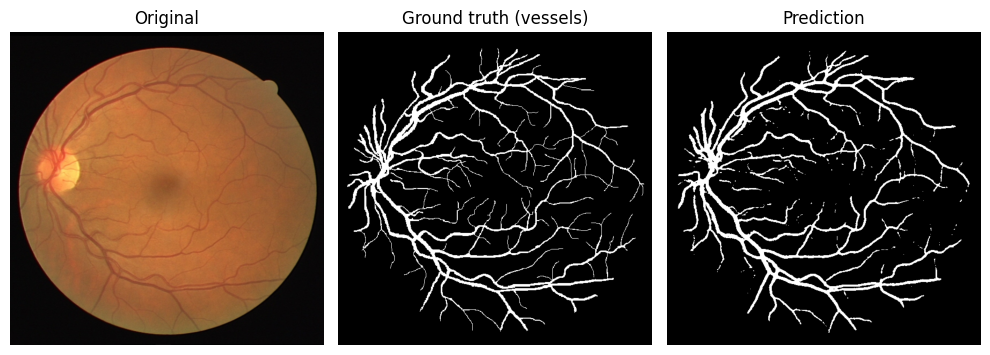

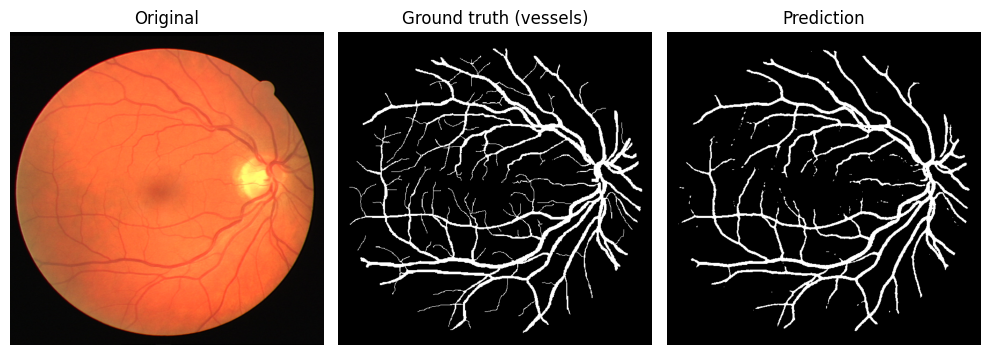

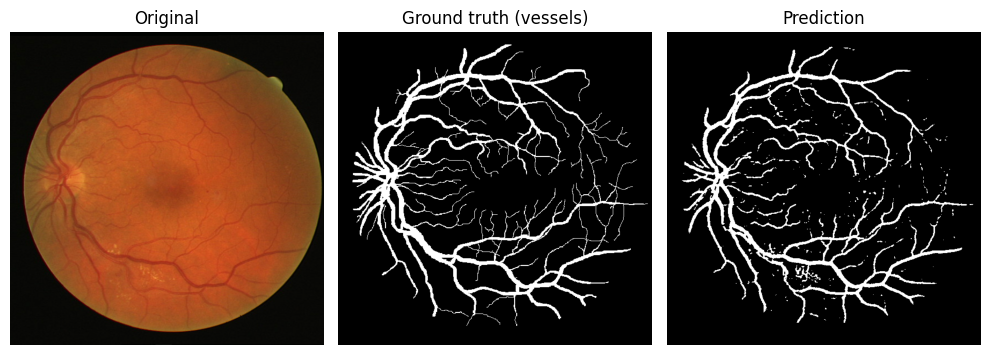

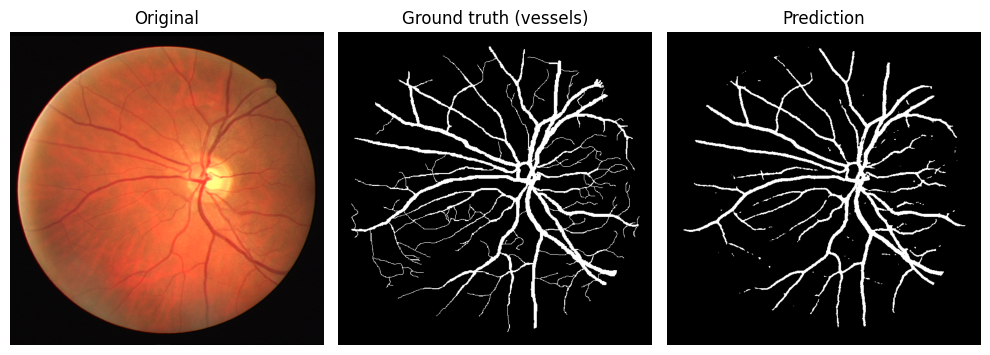

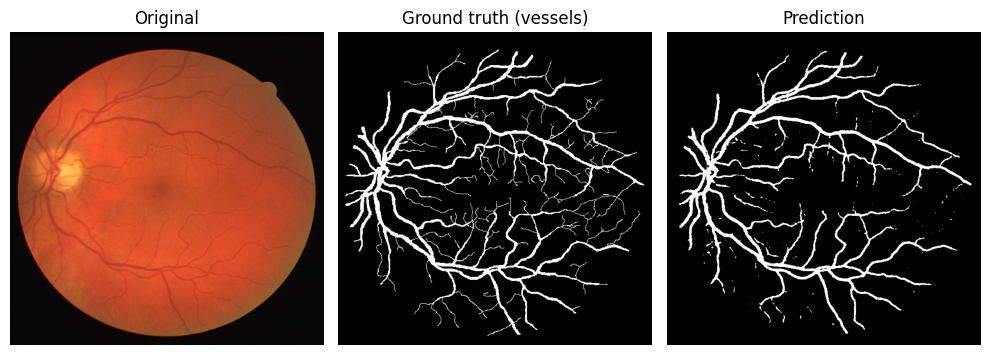

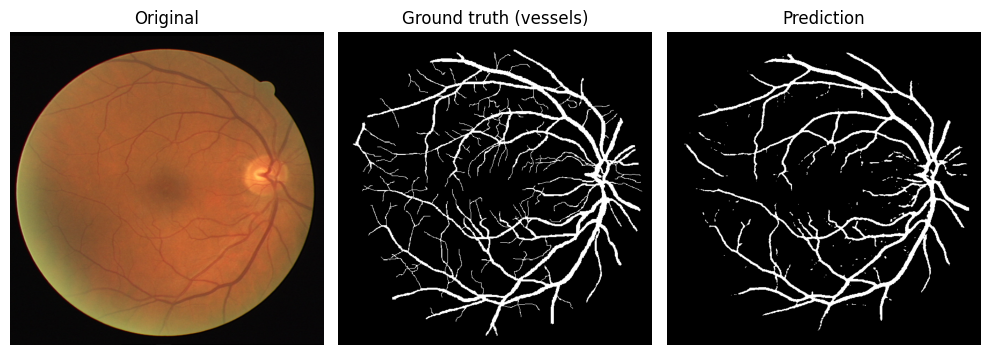

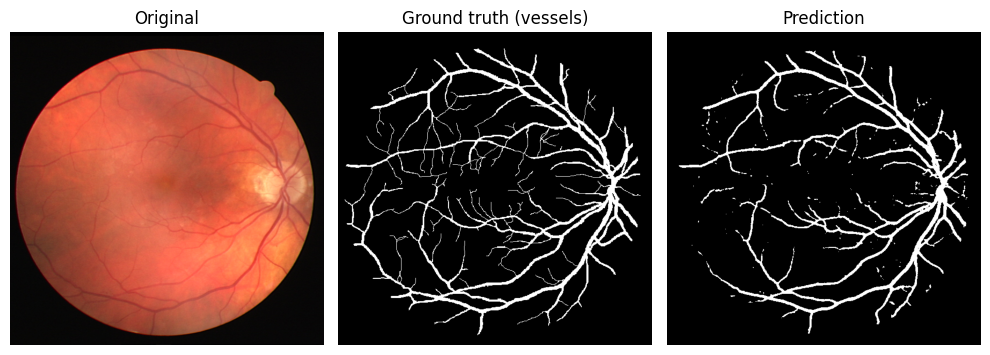

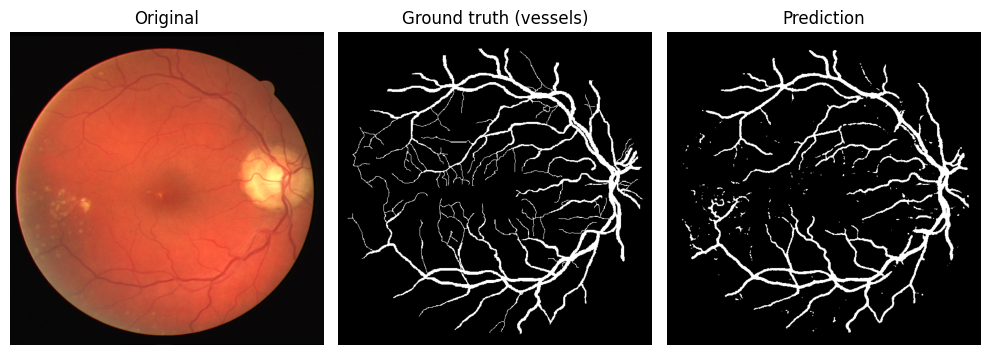

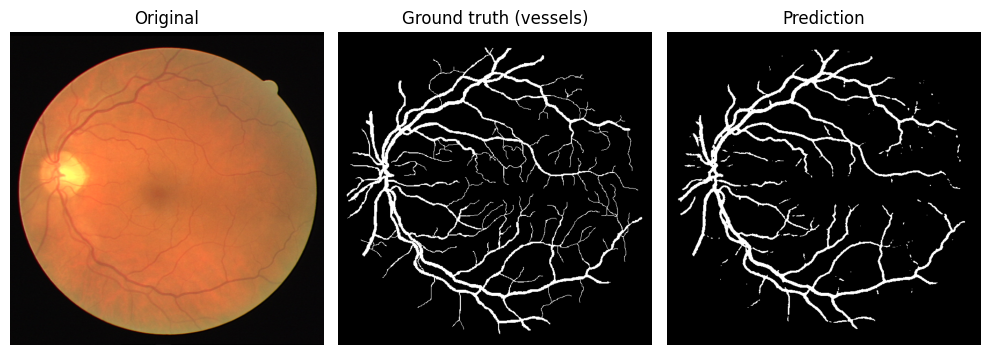

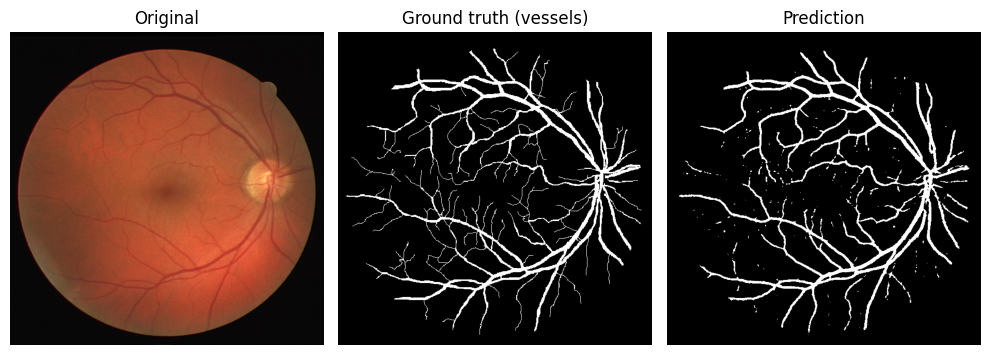

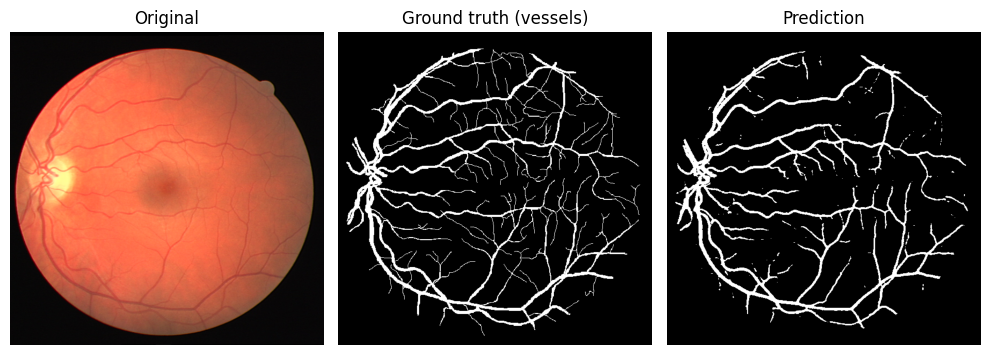

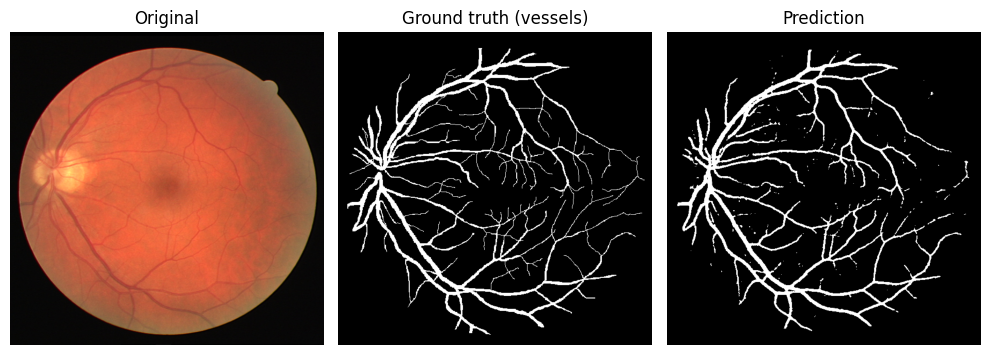

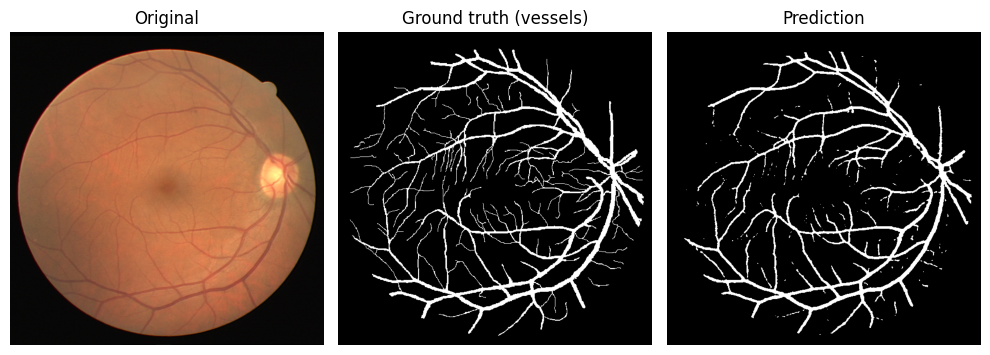

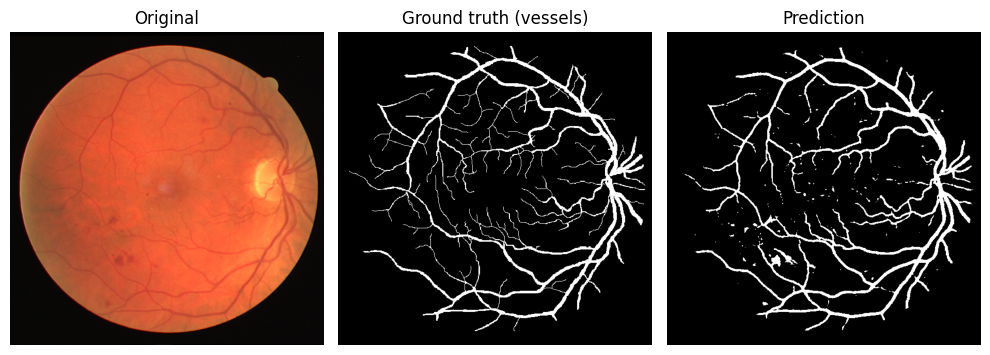

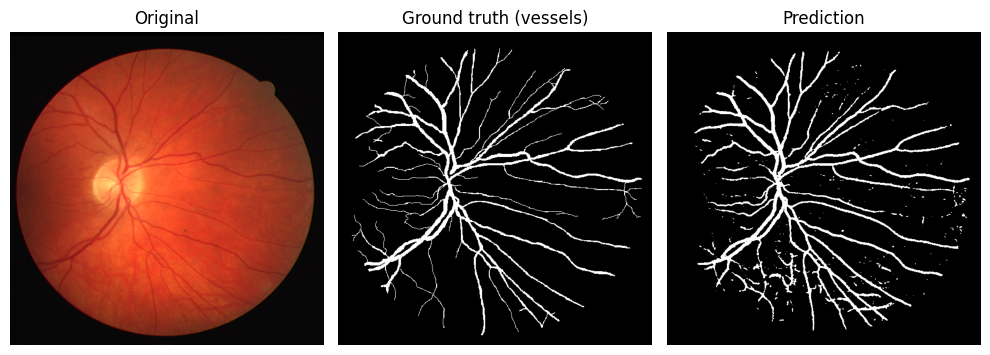

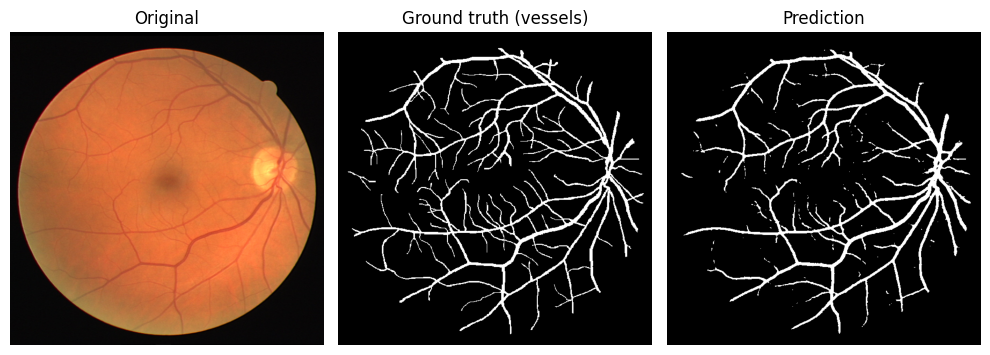

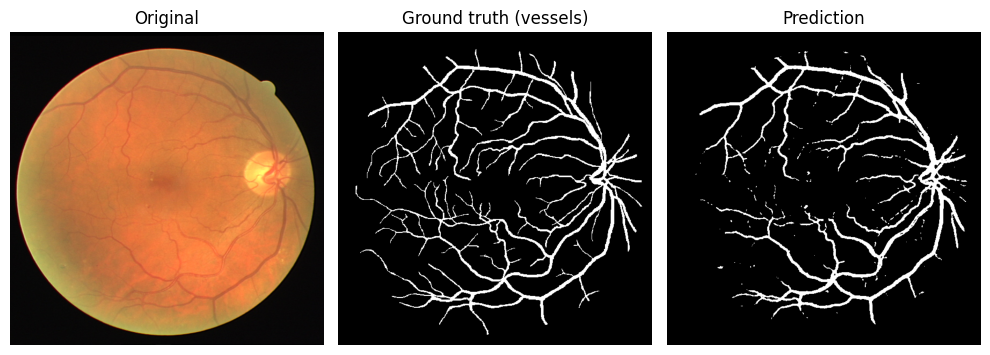

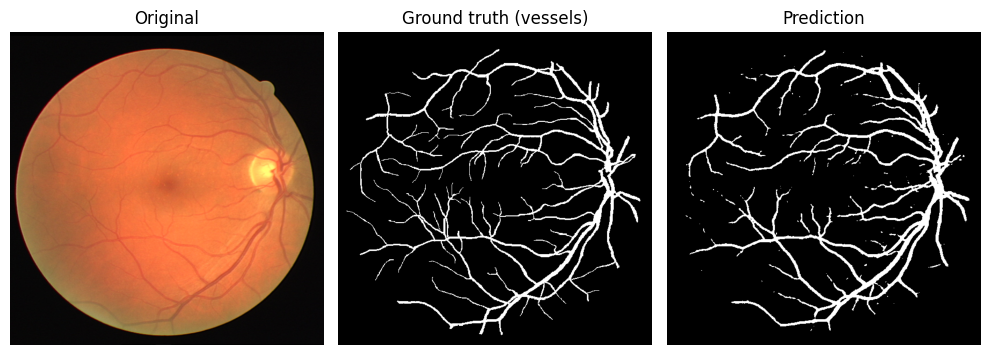

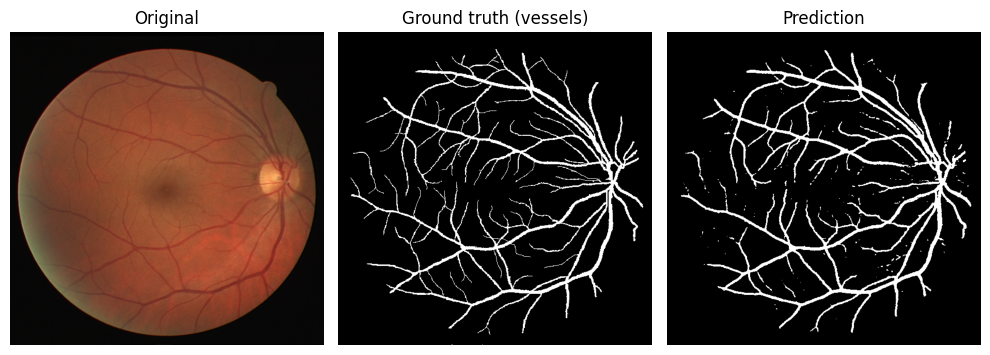

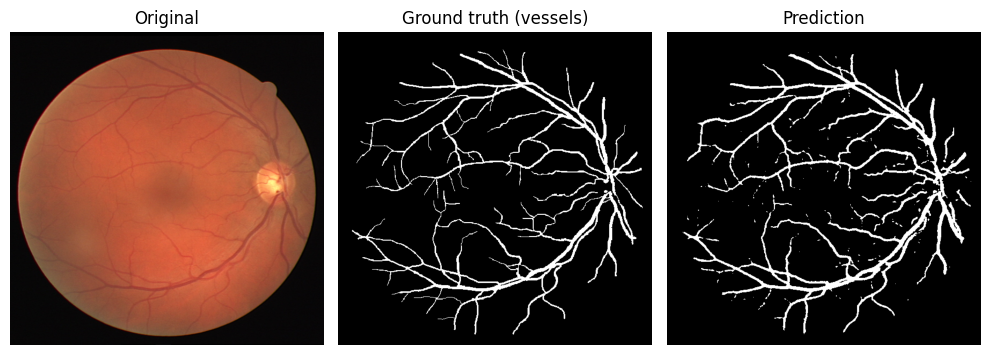

Triplets sauvegardés dans : /home/usrs/hnoel/Tohoku/Monai/UNet/UNet_DRIVE_v1/predictions_test_triplets


In [38]:
model.eval()

# 📁 Dossier pour sauvegarder les triplets
pred_dir = data_dir / "predictions_test_triplets"
pred_dir.mkdir(parents=True, exist_ok=True)

img_index = 0

with torch.no_grad():
    for batch in test_loader:
        imgs   = batch["image"].to(device)  # (B,3,H,W)
        labels = batch["label"].to(device)  # (B,1,H,W)
        fov    = batch["fov"].to(device)    # (B,1,H,W)

        logits = model(imgs)                # (B,2,H,W)
        preds  = logits.argmax(dim=1)       # (B,H,W)
        targets = labels.squeeze(1)         # (B,H,W)

        for i in range(imgs.size(0)):
            img_i  = imgs[i].cpu()
            gt_i   = targets[i].cpu()
            pred_i = preds[i].cpu()

            fig, ax = plt.subplots(1, 3, figsize=(10, 4))

            ax[0].imshow(img_i.permute(1, 2, 0))
            ax[0].set_title("Original")

            ax[1].imshow(gt_i, cmap="gray")
            ax[1].set_title("Ground truth (vessels)")

            ax[2].imshow(pred_i, cmap="gray")
            ax[2].set_title("Prediction")

            for a in ax:
                a.axis("off")

            plt.tight_layout()

            save_path = pred_dir / f"test_triplet_{img_index:02d}.png"
            plt.savefig(save_path, dpi=150, bbox_inches="tight")
            plt.show()

            img_index += 1

print(f"Triplets sauvegardés dans : {pred_dir}")

#### 10.3) Curves

In [40]:
def plot_metric(train_history, val_history, key, title=None, mark_best_on="val_loss", save_folder=data_dir):
    """
    key: nom de la métrique dans les dicts (ex: "loss", "dice", "auc")

    mark_best_on:
        - "val_loss" → marquer l'epoch où val_loss est minimal
        - "val_<key>" → marquer la meilleure valeur validation pour cette métrique (max)
    """

    train = train_history.get(key, [])
    val   = val_history.get(key, [])

    if len(val) == 0:
        print(f"⚠️ Impossible de tracer '{key}' (aucune valeur de validation trouvée)")
        return

    epochs = range(1, len(val) + 1)

    plt.figure(figsize=(7, 5))
    plt.plot(epochs, train, label=f"Train {key}", linewidth=2)
    plt.plot(epochs, val,   label=f"Val {key}", linewidth=2)

    # ======== BEST POINT (scatter) =========
    if mark_best_on == "val_loss" and "loss" in val_history:
        # meilleur = minimum
        best_e = int(np.argmin(val_history["loss"])) + 1
        best_v = val[best_e - 1]
        plt.scatter([best_e], [best_v], s=80, marker="o", color="red", zorder=3,
                    label=f"best @ epoch {best_e}")

    elif mark_best_on == f"val_{key}" and len(val) > 0:
        # meilleur = maximum
        best_e = int(np.nanargmax(val)) + 1
        best_v = val[best_e - 1]
        plt.scatter([best_e], [best_v], s=80, marker="o", color="red", zorder=3,
                    label=f"best @ epoch {best_e}")

    plt.xlabel("Epoch")
    plt.ylabel(key)
    plt.title(title or f"{key} (train vs val)")
    plt.grid(True)
    plt.legend()

    save_path = save_folder / f"{key}.png"
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    print(f"💾 Courbe sauvegardée : {save_path}")

    plt.show()

💾 Courbe sauvegardée : /home/usrs/hnoel/Tohoku/Monai/UNet/UNet_DRIVE_v1/loss.png


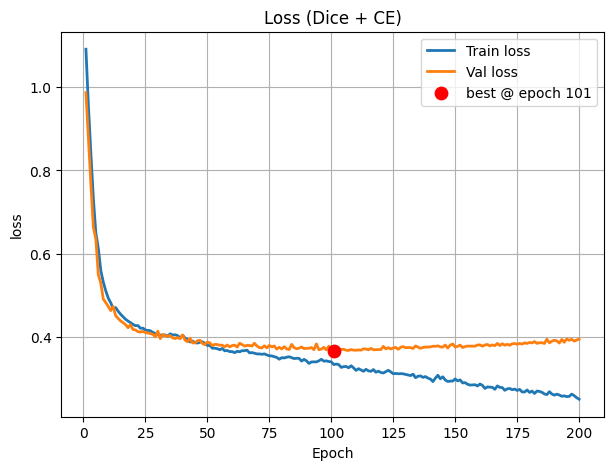

💾 Courbe sauvegardée : /home/usrs/hnoel/Tohoku/Monai/UNet/UNet_DRIVE_v1/dice.png


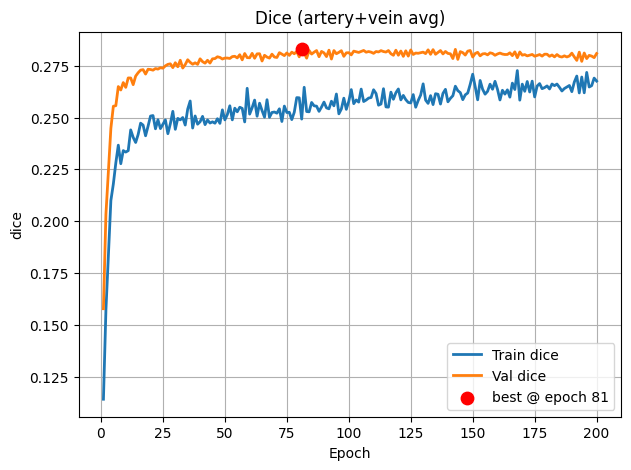

💾 Courbe sauvegardée : /home/usrs/hnoel/Tohoku/Monai/UNet/UNet_DRIVE_v1/auc.png


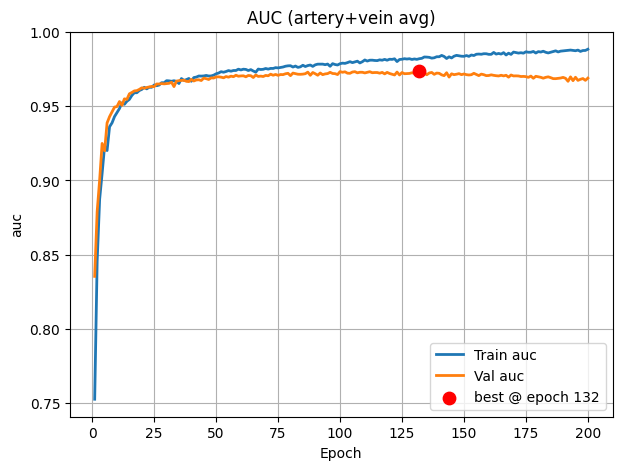

In [41]:
# Loss totale, Dice, AUC : même type de visualisation que dans ton notebook

plot_metric(train_history, val_history, "loss",
            title="Loss (Dice + CE)", mark_best_on="val_loss")

plot_metric(train_history, val_history, "dice",
            title="Dice (artery+vein avg)", mark_best_on="val_dice")

plot_metric(train_history, val_history, "auc",
            title="AUC (artery+vein avg)", mark_best_on="val_auc")

#### 10.3) Table of metrics

In [42]:
# ==== Évaluation globale sur le test ====

model.eval()

conf_sums_test = init_confmat_sums(num_classes=NUM_CLASSES)
auc_buf_test   = init_auc_buffers(classes=[VESSEL_CLASS])

with torch.no_grad():
    for batch in test_loader:
        imgs   = batch["image"].to(device)
        labels = batch["label"].to(device)   # (B,1,H,W)
        fov    = batch["fov"].to(device)     # (B,1,H,W)

        logits = model(imgs)                 # (B,2,H,W)
        preds  = logits.argmax(dim=1)        # (B,H,W)
        targets = labels.squeeze(1)          # (B,H,W)
        fov_bool = fov.squeeze(1).bool()     # (B,H,W)

        update_confmat_sums(conf_sums_test, preds, targets, NUM_CLASSES, fov=fov_bool)
        update_auc_buffers(auc_buf_test, logits, targets, fov=fov_bool)

vessel_metrics = compute_scalar_metrics_from_confmat(conf_sums_test, include_classes=[VESSEL_CLASS])
vessel_auc     = compute_mean_auc(auc_buf_test)

results = {
    "Vessel": {
        "accuracy":    vessel_metrics["accuracy"],
        "precision":   vessel_metrics["precision"],
        "recall":      vessel_metrics["recall"],
        "specificity": vessel_metrics["specificity"],
        "dice":        vessel_metrics["dice"],
        "IoU":         vessel_metrics["iou"],
        "AUC":         vessel_auc,
    }
}

df_global = pd.DataFrame(results).T.round(4)

print("\n=== Résultats globaux sur le test (FOV uniquement) ===\n")
display(df_global)

# Sauvegarde en CSV / JSON
metrics_csv_path  = data_dir / "metrics_global_test.csv"
metrics_json_path = data_dir / "metrics_global_test.json"

df_global.to_csv(metrics_csv_path)
df_global.to_json(metrics_json_path, orient="index")

print("→ Sauvegardé :")
print("  ", metrics_csv_path)
print("  ", metrics_json_path)


=== Résultats globaux sur le test (FOV uniquement) ===



accuracy  precision  recall  specificity    dice     IoU    AUC
Vessel    0.9617     0.7865  0.7728       0.9799  0.7796  0.6388  0.961

→ Sauvegardé :
   /home/usrs/hnoel/Tohoku/Monai/UNet/UNet_DRIVE_v1/metrics_global_test.csv
   /home/usrs/hnoel/Tohoku/Monai/UNet/UNet_DRIVE_v1/metrics_global_test.json


#### 10.4) Comparaison of the images

Barplots sauvegardés : /home/usrs/hnoel/Tohoku/Monai/UNet/UNet_DRIVE_v1/per_image_metrics_vessel_test.png


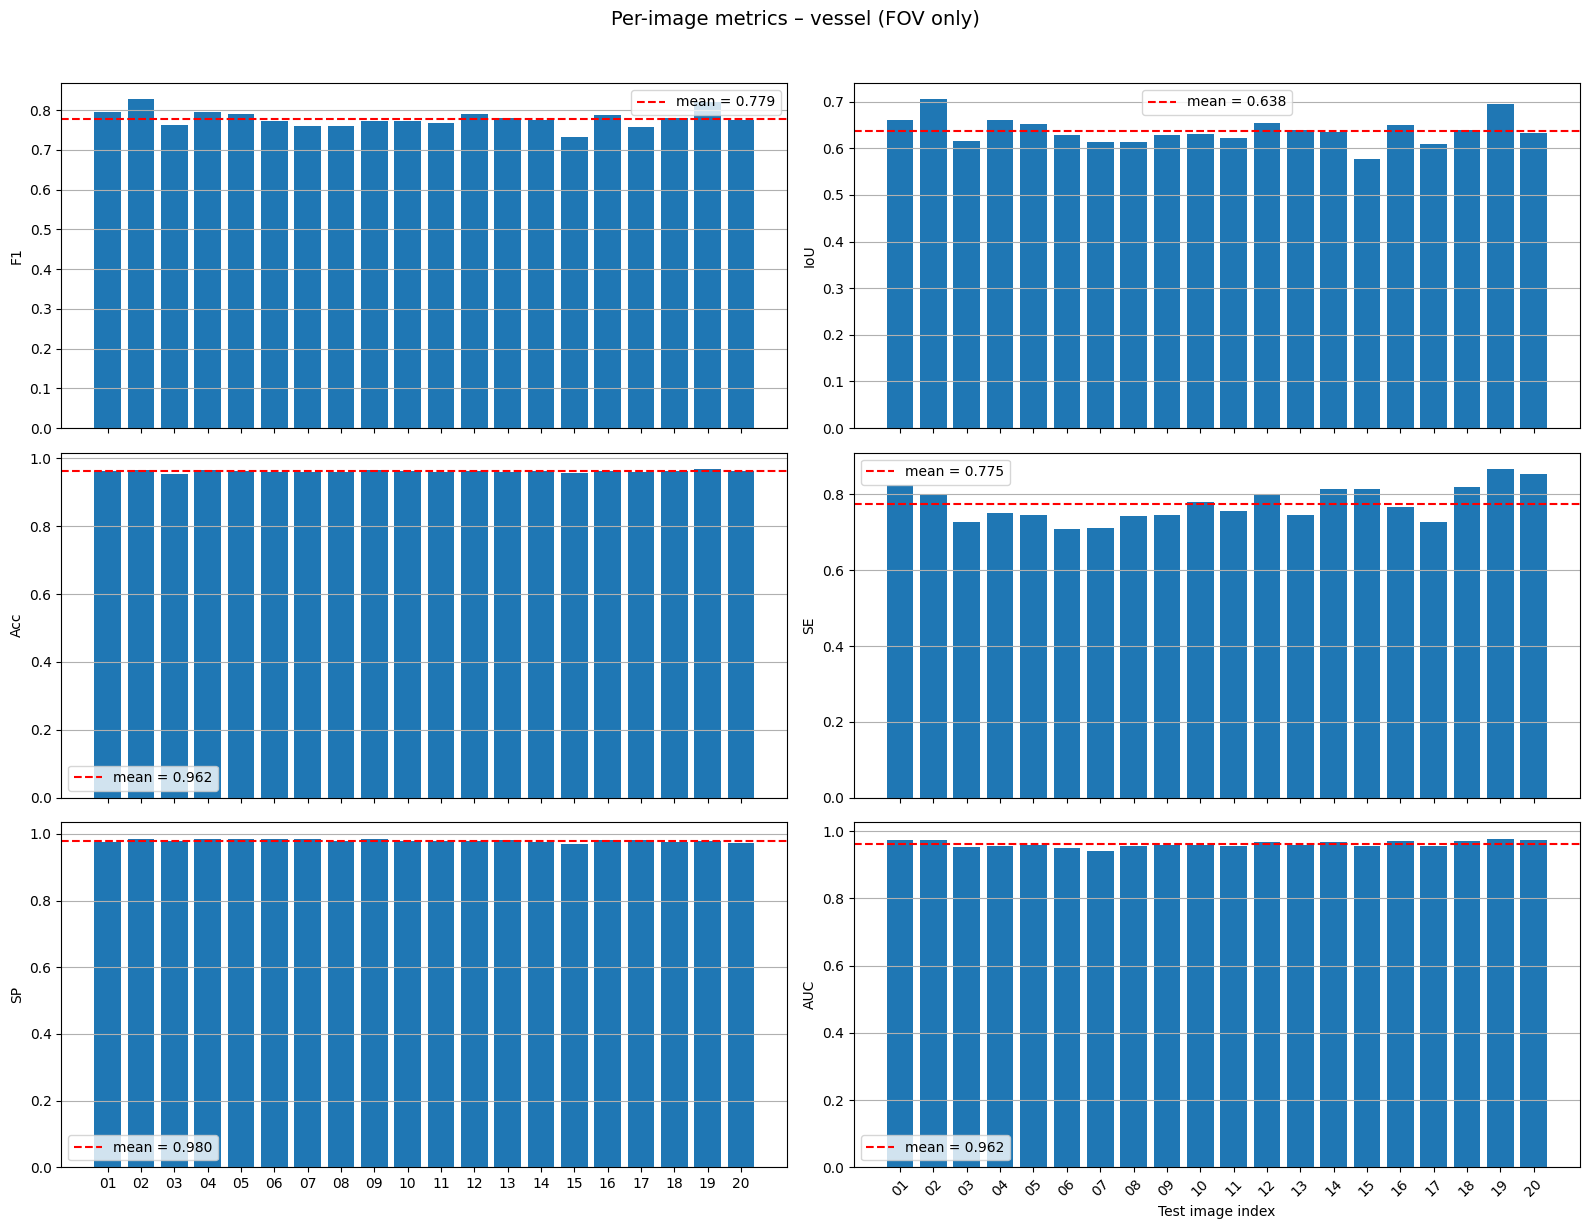

In [43]:
# ==== Helpers pour métriques par image ====

def confusion_binary(pred_bin: torch.Tensor, gt_bin: torch.Tensor):
    pred_bin = pred_bin.bool()
    gt_bin   = gt_bin.bool()
    TP = (pred_bin & gt_bin).sum().item()
    FP = (pred_bin & ~gt_bin).sum().item()
    FN = (~pred_bin & gt_bin).sum().item()
    TN = (~pred_bin & ~gt_bin).sum().item()
    return TP, FP, FN, TN


def metrics_from_conf(TP, FP, FN, TN):
    eps = 1e-7
    Acc  = (TP + TN) / max(TP + TN + FP + FN, eps)
    SE   = TP / max(TP + FN, eps)     # sensibilité (recall)
    SP   = TN / max(TN + FP, eps)
    Prec = TP / max(TP + FP, eps)
    F1   = 2 * Prec * SE / max(Prec + SE, eps)
    IoU  = TP / max(TP + FP + FN, eps)
    return F1, IoU, Acc, SE, SP


def auc_from_logits_one_class(logits_1img: torch.Tensor,
                              gt_1img: torch.Tensor,
                              fov_1img: torch.Tensor,
                              cls: int):
    with torch.no_grad():
        probs = F.softmax(logits_1img.unsqueeze(0), dim=1)[0]   # (C,H,W)
        prob_cls = probs[cls]                                   # (H,W)

        mask_flat = fov_1img.view(-1)
        y_score = prob_cls.view(-1)[mask_flat].cpu().numpy()
        y_true  = (gt_1img.view(-1)[mask_flat] == cls).cpu().numpy().astype(np.uint8)

        if (y_true == 1).sum() == 0 or (y_true == 0).sum() == 0:
            return float("nan")

        try:
            return float(roc_auc_score(y_true, y_score))
        except Exception:
            return float("nan")


# ==== Parcours du test pour métriques par image ====

model.eval()

metric_names = ["F1", "IoU", "Acc", "SE", "SP", "AUC"]
vessel_scores = {m: [] for m in metric_names}

img_indices = []  # index logique des images (0..19)

with torch.no_grad():
    current_idx = 0
    for batch in test_loader:
        imgs   = batch["image"].to(device)
        labels = batch["label"].to(device)   # (B,1,H,W)
        fov    = batch["fov"].to(device)     # (B,1,H,W)

        logits = model(imgs)                 # (B,2,H,W)
        preds  = logits.argmax(dim=1)        # (B,H,W)
        targets = labels.squeeze(1)          # (B,H,W)
        fov_bool = fov.squeeze(1).bool()     # (B,H,W)

        for i in range(imgs.size(0)):
            gt_i   = targets[i]
            pred_i = preds[i]
            fov_i  = fov_bool[i]
            log_i  = logits[i]

            # Binaire "vessel" vs reste, restreint au FOV
            pred_v = (pred_i == VESSEL_CLASS) & fov_i
            gt_v   = (gt_i == VESSEL_CLASS) & fov_i

            TP, FP, FN, TN = confusion_binary(pred_v, gt_v)
            F1, IoU, Acc, SE, SP = metrics_from_conf(TP, FP, FN, TN)
            AUC = auc_from_logits_one_class(log_i, gt_i, fov_i, VESSEL_CLASS)

            vessel_scores["F1"].append(F1)
            vessel_scores["IoU"].append(IoU)
            vessel_scores["Acc"].append(Acc)
            vessel_scores["SE"].append(SE)
            vessel_scores["SP"].append(SP)
            vessel_scores["AUC"].append(AUC)

            img_indices.append(current_idx)
            current_idx += 1

# ==== Barplots + moyennes ====

n_images = len(img_indices)
x = np.arange(n_images)

fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex=True)
axes = axes.ravel()

for ax, m in zip(axes, metric_names):
    vals = np.array(vessel_scores[m], dtype=float)
    ax.bar(x, vals)
    mean_val = np.nanmean(vals)
    ax.axhline(mean_val, color="red", linestyle="--", label=f"mean = {mean_val:.3f}")
    ax.set_ylabel(m)
    ax.grid(True, axis="y")
    ax.legend()

axes[-1].set_xticks(x)
axes[-1].set_xticklabels([f"{i+1:02d}" for i in x], rotation=45)
axes[-1].set_xlabel("Test image index")

plt.suptitle("Per-image metrics – vessel (FOV only)", y=1.02, fontsize=14)

bars_path = data_dir / "per_image_metrics_vessel_test.png"
plt.tight_layout()
plt.savefig(bars_path, dpi=200, bbox_inches="tight")

print(f"Barplots sauvegardés : {bars_path}")
plt.show()